# Computer Vision Project

### Setup

In [101]:
import os
import importlib
from tqdm import tqdm

# Torch modules
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch import amp

# Custom modules
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import preprocessing, model_utils

import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import PointDataset

from models.unet_model import UNET


In [102]:
# Defining some constants that will be used throughout the notebook
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

### Splitting the TrainVal data into training and validation data
* Splitting into training and validations sets is needed so we can evaluate peformance on the model while training.
* More common than K-fold cross validation in deep learning settings because of computational costs.

In [103]:
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)


### Custom Dataset

In [104]:
test_augmentation = preprocessing.get_validation_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
train_augmentation = preprocessing.get_training_augmentation()


train_dataset = CVDataset(x_train_fps, y_train_fps, preprocessing=preprocessing_fn, augmentation=train_augmentation)
valid_dataset = CVDataset(x_val_fps, y_val_fps)

test_dataset  = CVDataset(
                x_test_fps[:10],
                y_test_fps[:10],
                augmentation = test_augmentation,
                preprocessing=preprocessing_fn
                )


# Printing the size of each dataset
print(f'Training dataset has size {train_dataset.__len__()}')
print(f'Validation dataset has size {valid_dataset.__len__()}')
print(f'Testing dataset has size {test_dataset.__len__()}')

Training dataset has size 2938
Validation dataset has size 735
Testing dataset has size 10


In [14]:
test_dataset.original_dimensions

AttributeError: 'CVDataset' object has no attribute 'original_dimensions'

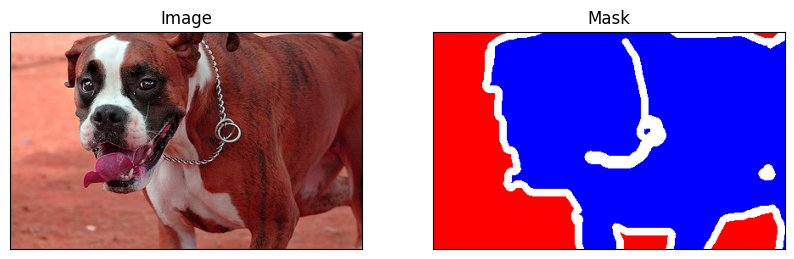

In [15]:

image, mask = train_dataset[23]
c_mask = colorise_mask(mask, VisualisationConstants.palette)
visualise_data(image = image, mask = c_mask)


In [16]:
colorise_mask(mask, VisualisationConstants.palette).shape

torch.Size([3, 256, 416])

## Saving the model

In [17]:
# 0. Create your model and train it
model = unet_model.UNET(in_channels=3, out_channels=3)
# train function/code or whatever you need to use

# 1. get the state dict for the model (weights etc)
#    This is a built in method if model inherits from nn.Module
state_dict = model.state_dict()

# 2. Create a checkpoint
checkpoint = {'state_dict': state_dict, # 'state_dict' key name must be named state_dict exactly
              'epochs':10,              # Add optional additional elements to the checkpoint for experiment tracking
              'learning_rate': 10}      # these can be named whatever you like, and there can be as many as you like

# 3. save the checkpoint to your computer/google colab files
model_utils.save_checkpoint(
    checkpoint,
    'test.pth'  # Where you want to save & filename, if you want to save to folder called 'checkpoints' for instance, just change to 'checkpoints/test.pth'
    )

NameError: name 'unet_model' is not defined

## Loading the model 

In [105]:
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import ModelEval

ImportError: cannot import name 'ModelEval' from 'segmentation.utils' (/Users/georgeboutselis/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Year 4/Semester 2/Computer Vision/Computer-Vision-Project/segmentation/utils.py)

## Point based segmentation

In [270]:
import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import CVDataset
from segmentation.dataset import PointDataset
import segmentation.utils
importlib.reload(segmentation.utils)

import torchvision.transforms.functional as TF
import torch

In [228]:
from segmentation.eval import *

In [271]:
train_augmentation = preprocessing.get_training_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
val_augmentation = preprocessing.get_validation_augmentation()

train_dataset = PointDataset(x_train_fps[:5], y_train_fps[:5], augmentation=train_augmentation, concat_heatmap=False)
val_dataset  = PointDataset(x_val_fps, y_val_fps, augmentation=val_augmentation, preprocessing=preprocessing_fn)

train_loader = DataLoader(train_dataset,batch_size= 8,num_workers=4,pin_memory=True,shuffle=True)

In [223]:
np.array

NameError: name 'np' is not defined

original mask has shape (333, 500)
prompt point is [350, 69]
keypoint is :[[337.0, 68.0]]


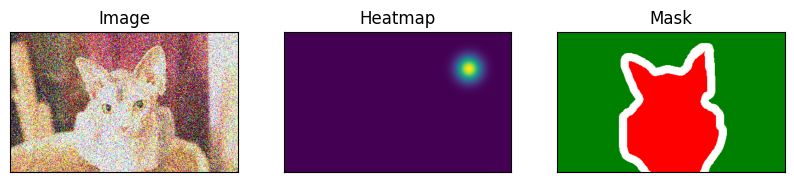

In [357]:
from segmentation.show import *
from segmentation.constants import VisualisationConstants
image, mask, heatmap = train_dataset[1]

mask = colorise_mask(mask, palette=VisualisationConstants.palette)
visualise_data(image = image, heatmap = heatmap, mask = mask)

In [78]:
np.unique(mask)

array([0, 1])

In [139]:
from segmentation.dataset import CVDataset
train_dataset = CVDataset(x_train_fps[:5], y_train_fps[:5], augmentation=train_augmentation)
image, mask = train_dataset[1]

In [239]:
def sample_prompt(mask, p = 0.5):
    '''
    sample from object with probability p
    sample from background with probability 1-p
    '''
    # Getting which pixels are in the image
    unique_pixels = np.unique(mask)
    non_border_pxiels = np.sort(unique_pixels[unique_pixels != 255])
    index = 1 if np.random.random() < p else 0
    object = unique_pixels[index]

    class_coords = np.argwhere(mask == object)
    idx = np.random.choice(len(class_coords))
    return class_coords[idx]


    


In [254]:
sample_prompt(mask)

array([168,  77])

In [219]:
from segmentation.eval import predict

In [220]:
image = image.float()
predict(image, unet_model)

AttributeError: 'numpy.ndarray' object has no attribute 'float'